<a href="https://colab.research.google.com/github/milvus-io/bootcamp/blob/master/bootcamp/tutorials/integration/mistral_ocr_with_milvus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>   <a href="https://github.com/milvus-io/bootcamp/blob/master/bootcamp/tutorials/integration/mistral_ocr_with_milvus.ipynb" target="_blank">
    <img src="https://img.shields.io/badge/View%20on%20GitHub-555555?style=flat&logo=github&logoColor=white" alt="GitHub Repository"/>
</a>


# Document Understanding with Mistral OCR and Milvus

This tutorial demonstrates how to build a document understanding system using:

## Mistral OCR
A powerful optical character recognition service that:
* Processes PDFs, images, and other document formats
* Preserves document structure and formatting
* Handles multi-page documents
* Recognizes tables, lists, and other complex elements

## Mistral Embeddings
* Transforms text into numerical representations:
* Converts text into 1024-dimensional vectors
* Captures semantic relationships between concepts
* Enables similarity matching based on meaning
* Provides foundation for semantic search

## Milvus Vector Database
Specialized database for vector similarity search:
* Open-Source
* Performs efficient Vector Search
* Scales to large document collections
* Supports hybrid search (vector similarity + metadata filtering)
* Optimized for AI applications

By the end of this tutorial, you'll have a system that can:
1. Process documents (PDFs/images) via URLs
2. Extract text using OCR
3. Store the text and vector embeddings in Milvus
4. Perform semantic search across your document collection

---

## Setup and Dependencies

First, let's install the required packages:

In [1]:
!pip install mistralai pymilvus python-dotenv


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


## Environment Setup

You'll need:
1. A Mistral API key (get one at https://console.mistral.ai/)
2. Milvus running locally through [Docker](https://milvus.io/docs/install_standalone-docker.md) or with [Zilliz Cloud](https://zilliz.com) 

Let's set up our environment:

In [1]:
import json
import os
import re

from dotenv import load_dotenv
from mistralai import Mistral
from pymilvus import CollectionSchema, DataType, FieldSchema, MilvusClient
from pymilvus.client.types import LoadState

# Load environment variables from .env file
load_dotenv()

# Initialize clients
api_key = os.getenv("MISTRAL_API_KEY")
if not api_key:
    api_key = input("Enter your Mistral API key: ")
    os.environ["MISTRAL_API_KEY"] = api_key

client = Mistral(api_key=api_key)

# Define models
text_model = "mistral-small-latest"  # For chat interactions
ocr_model = "mistral-ocr-latest"  # For OCR processing
embedding_model = "mistral-embed"  # For generating embeddings

# Connect to Milvus (default: localhost)
milvus_uri = os.getenv("MILVUS_URI", "http://localhost:19530")
milvus_client = MilvusClient(uri=milvus_uri)

# Milvus collection name
COLLECTION_NAME = "document_ocr"

print(f"Connected to Mistral API and Milvus at {milvus_uri}")

Connected to Mistral API and Milvus at http://localhost:19530


## Setting Up Milvus Collection

Now, let's create a Milvus collection to store our document data. The collection will have the following fields:
- `id`: Primary key (auto-generated)
- `url`: Source URL of the document
- `page_num`: Page number within the document
- `content`: Extracted text content
- `embedding`: Vector representation of the content (1024 dimensions)

In [2]:
def setup_milvus_collection():
    """Create Milvus collection if it doesn't exist."""
    # Check if collection already exists
    if milvus_client.has_collection(COLLECTION_NAME):
        print(f"Collection '{COLLECTION_NAME}' already exists.")
        return

    # Define collection schema
    fields = [
        FieldSchema(name="id", dtype=DataType.INT64, is_primary=True, auto_id=True),
        FieldSchema(name="url", dtype=DataType.VARCHAR, max_length=500),
        FieldSchema(name="page_num", dtype=DataType.INT64),
        FieldSchema(name="content", dtype=DataType.VARCHAR, max_length=65535),
        FieldSchema(name="embedding", dtype=DataType.FLOAT_VECTOR, dim=1024),
    ]

    schema = CollectionSchema(fields=fields)

    # Create collection
    milvus_client.create_collection(
        collection_name=COLLECTION_NAME,
        schema=schema,
    )

    # Create index for vector search
    index_params = milvus_client.prepare_index_params()
    index_params.add_index(
        field_name="embedding",
        index_type="IVF_FLAT",  # Index type for approximate nearest neighbor search
        metric_type="COSINE",  # Similarity metric
        params={"nlist": 128},  # Number of clusters
    )

    milvus_client.create_index(
        collection_name=COLLECTION_NAME, index_params=index_params
    )

    print(f"Collection '{COLLECTION_NAME}' created successfully with index.")


setup_milvus_collection()

Collection 'document_ocr' already exists.


## Core Functionality

Let's implement the core functions for our document understanding system:

In [3]:
# Generate embeddings using Mistral
def generate_embedding(text):
    """Generate embedding for text using Mistral embedding model."""
    response = client.embeddings.create(model=embedding_model, inputs=[text])
    return response.data[0].embedding


# Store OCR results in Milvus
def store_ocr_in_milvus(url, ocr_result):
    """Process OCR results and store in Milvus."""
    # Extract pages from OCR result
    pages = []
    current_page = ""
    page_num = 0

    for line in ocr_result.split("\n"):
        if line.startswith("### Page "):
            if current_page:
                pages.append((page_num, current_page.strip()))
            page_num = int(line.replace("### Page ", ""))
            current_page = ""
        else:
            current_page += line + "\n"

    # Add the last page
    if current_page:
        pages.append((page_num, current_page.strip()))

    # Prepare data for Milvus
    entities = []
    for page_num, content in pages:
        # Generate embedding for the page content
        embedding = generate_embedding(content)

        # Create entity
        entity = {
            "url": url,
            "page_num": page_num,
            "content": content,
            "embedding": embedding,
        }
        entities.append(entity)

    # Insert into Milvus
    if entities:
        milvus_client.insert(collection_name=COLLECTION_NAME, data=entities)
        print(f"Stored {len(entities)} pages from {url} in Milvus.")

    return len(entities)


# Define OCR function
def perform_ocr(url):
    """Apply OCR to a URL (PDF or image)."""
    try:
        # Try PDF OCR first
        response = client.ocr.process(
            model=ocr_model, document={"type": "document_url", "document_url": url}
        )
    except Exception:
        try:
            # If PDF OCR fails, try Image OCR
            response = client.ocr.process(
                model=ocr_model, document={"type": "image_url", "image_url": url}
            )
        except Exception as e:
            return str(e)  # Return error message

    # Format the OCR results
    ocr_result = "\n\n".join(
        [
            f"### Page {i + 1}\n{response.pages[i].markdown}"
            for i in range(len(response.pages))
        ]
    )

    # Store in Milvus
    store_ocr_in_milvus(url, ocr_result)

    return ocr_result


# Process URLs
def process_document(url):
    """Process a document URL and return its contents."""
    print(f"Processing document: {url}")
    ocr_result = perform_ocr(url)
    return ocr_result

## Search Functionality

Now, let's implement the search functionality to retrieve relevant document content:

In [4]:
def search_documents(query, limit=5):
    """Search Milvus for similar content to the query."""
    # Check if collection exists
    if not milvus_client.has_collection(COLLECTION_NAME):
        return "No documents have been processed yet."

    # Load collection if not already loaded
    if milvus_client.get_load_state(COLLECTION_NAME) != LoadState.Loaded:
        milvus_client.load_collection(COLLECTION_NAME)

    print(f"Searching for: {query}")
    query_embedding = generate_embedding(query)

    search_params = {"metric_type": "COSINE", "params": {"nprobe": 10}}

    search_results = milvus_client.search(
        collection_name=COLLECTION_NAME,
        data=[query_embedding],
        anns_field="embedding",
        search_params=search_params,
        limit=limit,
        output_fields=["url", "page_num", "content"],
    )

    results = []

    if not search_results or not search_results[0]:
        return "No matching documents found."

    for i, hit in enumerate(search_results[0]):
        url = hit["entity"]["url"]
        page_num = hit["entity"]["page_num"]
        content = hit["entity"]["content"]
        score = hit["distance"]

        results.append(
            {
                "rank": i + 1,
                "score": score,
                "url": url,
                "page": page_num,
                "content": content[:500] + "..." if len(content) > 500 else content,
            }
        )

    return results


# Get statistics about stored documents
def get_document_stats():
    """Get statistics about documents stored in Milvus."""
    if not milvus_client.has_collection(COLLECTION_NAME):
        return "No documents have been processed yet."

    # Get collection stats
    stats = milvus_client.get_collection_stats(COLLECTION_NAME)
    row_count = stats["row_count"]

    # Get unique URLs
    results = milvus_client.query(
        collection_name=COLLECTION_NAME, filter="", output_fields=["url"], limit=10000
    )

    unique_urls = set()
    for result in results:
        unique_urls.add(result["url"])

    return {
        "total_pages": row_count,
        "unique_documents": len(unique_urls),
        "documents": list(unique_urls),
    }

## Demo: Processing Documents

Let's process some example documents. You can replace these URLs with your own documents.

In [5]:
# Example PDF URL (Mistral AI paper)
pdf_url = "https://arxiv.org/pdf/2310.06825.pdf"

# Process the document
ocr_result = process_document(pdf_url)

# Display a preview of the OCR result
print("\nOCR Result Preview:")
print("====================")
print(ocr_result[:1000] + "...")

Processing document: https://arxiv.org/pdf/2310.06825.pdf
Stored 9 pages from https://arxiv.org/pdf/2310.06825.pdf in Milvus.

OCR Result Preview:
### Page 1
# Mistral 7B 

Albert Q. Jiang, Alexandre Sablayrolles, Arthur Mensch, Chris Bamford, Devendra Singh Chaplot, Diego de las Casas, Florian Bressand, Gianna Lengyel, Guillaume Lample, Lucile Saulnier, Lélio Renard Lavaud, Marie-Anne Lachaux, Pierre Stock, Teven Le Scao, Thibaut Lavril, Thomas Wang, Timothée Lacroix, William El Sayed

![img-0.jpeg](img-0.jpeg)


#### Abstract

We introduce Mistral 7B, a 7-billion-parameter language model engineered for superior performance and efficiency. Mistral 7B outperforms the best open 13B model (Llama 2) across all evaluated benchmarks, and the best released 34B model (Llama 1) in reasoning, mathematics, and code generation. Our model leverages grouped-query attention (GQA) for faster inference, coupled with sliding window attention (SWA) to effectively handle sequences of arbitrary length wit

Let's process an image as well:

In [6]:
# Example image URL (replace with your own)
image_url = "https://s3.eu-central-1.amazonaws.com/readcoop.cis.public-assets.prod/hero/old-german-scripts.png"

# Process the image
try:
    ocr_result = process_document(image_url)
    print("\nImage OCR Result:")
    print("=================")
    print(ocr_result)
except Exception as e:
    print(f"Error processing image: {e}")

Processing document: https://s3.eu-central-1.amazonaws.com/readcoop.cis.public-assets.prod/hero/old-german-scripts.png
Stored 1 pages from https://s3.eu-central-1.amazonaws.com/readcoop.cis.public-assets.prod/hero/old-german-scripts.png in Milvus.

Image OCR Result:
### Page 1
![img-0.jpeg](img-0.jpeg)
![img-1.jpeg](img-1.jpeg)
![img-2.jpeg](img-2.jpeg)
![img-3.jpeg](img-3.jpeg)
![img-4.jpeg](img-4.jpeg)
![img-5.jpeg](img-5.jpeg)
![img-6.jpeg](img-6.jpeg)
![img-7.jpeg](img-7.jpeg)
![img-8.jpeg](img-8.jpeg)
![img-9.jpeg](img-9.jpeg)
![img-10.jpeg](img-10.jpeg)
![img-11.jpeg](img-11.jpeg)
![img-12.jpeg](img-12.jpeg)
![img-13.jpeg](img-13.jpeg)
![img-14.jpeg](img-14.jpeg)
![img-15.jpeg](img-15.jpeg)
![img-16.jpeg](img-16.jpeg)
![img-17.jpeg](img-17.jpeg)
![img-18.jpeg](img-18.jpeg)
![img-19.jpeg](img-19.jpeg)
![img-20.jpeg](img-20.jpeg)
![img-21.jpeg](img-21.jpeg)
![img-22.jpeg](img-22.jpeg)
![img-23.jpeg](img-23.jpeg)
![img-24.jpeg](img-24.jpeg)
![img-25.jpeg](img-25.jpeg)
![img-26.jpeg]

## Demo: Searching Documents

Now that we've processed some documents, let's search through them:

In [7]:
# Get document statistics
stats = get_document_stats()
print(f"Total pages stored: {stats['total_pages']}")
print(f"Unique documents: {stats['unique_documents']}")
print("\nProcessed documents:")
for i, url in enumerate(stats["documents"]):
    print(f"{i + 1}. {url}")

Total pages stored: 58
Unique documents: 3

Processed documents:
1. https://arxiv.org/pdf/2310.06825.pdf
2. https://s3.eu-central-1.amazonaws.com/readcoop.cis.public-assets.prod/hero/old-german-scripts.png
3. https://arxiv.org/pdf/2410.07073


In [8]:
# Search for information
query = "What is Mistral 7B?"
results = search_documents(query, limit=3)

print(f"Search results for: '{query}'\n")

if isinstance(results, str):
    print(results)
else:
    for result in results:
        print(f"Result {result['rank']} (Score: {result['score']:.2f})")
        print(f"Source: {result['url']} (Page {result['page']})")
        print(f"Content: {result['content']}\n")

Searching for: What is Mistral 7B?
Search results for: 'What is Mistral 7B?'

Result 1 (Score: 0.83)
Source: https://arxiv.org/pdf/2310.06825.pdf (Page 2)
Content: Mistral 7B is released under the Apache 2.0 license. This release is accompanied by a reference implementation ${ }^{1}$ facilitating easy deployment either locally or on cloud platforms such as AWS, GCP, or Azure using the vLLM [17] inference server and SkyPilot ${ }^{2}$. Integration with Hugging Face ${ }^{3}$ is also streamlined for easier integration. Moreover, Mistral 7B is crafted for ease of fine-tuning across a myriad of tasks. As a demonstration of its adaptability and superior perform...

Result 2 (Score: 0.83)
Source: https://arxiv.org/pdf/2310.06825.pdf (Page 2)
Content: Mistral 7B is released under the Apache 2.0 license. This release is accompanied by a reference implementation ${ }^{1}$ facilitating easy deployment either locally or on cloud platforms such as AWS, GCP, or Azure using the vLLM [17] inference s

Try another search query:

In [9]:
# Search for more specific information
query = "What are the capabilities of Mistral's language models?"
results = search_documents(query, limit=3)

print(f"Search results for: '{query}'\n")

if isinstance(results, str):
    print(results)
else:
    for result in results:
        print(f"Result {result['rank']} (Score: {result['score']:.2f})")
        print(f"Source: {result['url']} (Page {result['page']})")
        print(f"Content: {result['content']}\n")

Searching for: What are the capabilities of Mistral's language models?
Search results for: 'What are the capabilities of Mistral's language models?'

Result 1 (Score: 0.85)
Source: https://arxiv.org/pdf/2310.06825.pdf (Page 2)
Content: Mistral 7B is released under the Apache 2.0 license. This release is accompanied by a reference implementation ${ }^{1}$ facilitating easy deployment either locally or on cloud platforms such as AWS, GCP, or Azure using the vLLM [17] inference server and SkyPilot ${ }^{2}$. Integration with Hugging Face ${ }^{3}$ is also streamlined for easier integration. Moreover, Mistral 7B is crafted for ease of fine-tuning across a myriad of tasks. As a demonstration of its adaptability and superior perform...

Result 2 (Score: 0.85)
Source: https://arxiv.org/pdf/2310.06825.pdf (Page 2)
Content: Mistral 7B is released under the Apache 2.0 license. This release is accompanied by a reference implementation ${ }^{1}$ facilitating easy deployment either locally or on cl

## Conclusion

In this tutorial, we've built a complete document understanding system using Mistral OCR and Milvus. This system can:

1. Process documents from URLs
2. Extract text using Mistral's OCR capabilities
3. Generate vector embeddings for the content
4. Store both text and vectors in Milvus
5. Perform semantic search across all processed documents

This approach enables powerful document understanding capabilities that go beyond simple keyword matching, allowing users to find information based on meaning rather than exact text matches.

## ⭐️ Github
We hope you liked this tutorial showcasing how to use Milvus with OpenAI Agents. If you liked it and our project, please give us a **[star on Github](https://github.com/milvus-io/milvus)**! ⭐

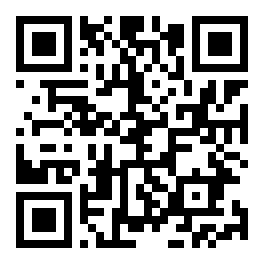

## 🤝 Add me on Linkedin!
If you have some questions related to Milvus, GenAI, etc, I am Stephen Batifol, you can add me on LinkedIn and I'll gladly help you.

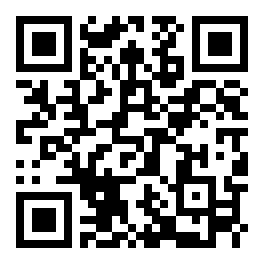

## 💬 Join our Discord
If you're interested in learning more about Milvus or you wanna share some feedback, feel free to **join our [Discord](https://zilliz.com/discord) channel**.
